# 1. Préambule

## Origine du projet

Nous avons choisi pour sujet l'étude du "pricing" des cartes pokémons, c'est à dire l'étude du prix auquel se vendent les cartes. Ce sujet nous a paru adapter à ce travail de programmation pour plusieurs raisons. Tout d'abord, nous avons accès à beaucoup de données, potentiellement diversifiées via différents site. Ensuite, il est relativement concret, on peut donc comparer ce que propose nos modèles avec ce qui parait intuitivement vrai. Finalement, il nous paraissait amusant et intéressait toutes les personnes du groupe.

## Problématique et délimitation pratique du sujet

On cherche à prédire le prix de vente des cartes pokémons à partir d'autres variables d'intérêt, tel que la rareté, l'utilisation de la carte dans des tournoi récents, des données de prix antérieures. On se limite en pratique aux données de prix du site "Magic Card Market", site laissant des acheteurs et vendeurs interragir pour echanger des cartes. L'offre et la demande importante sur ce site permettent d'avoir un prix réaliste, et non augmenté par un éventuel intermédiaire qui doit encaisser une marge, augmentant donc le prix de vente. On se limite également aux cartes récentes (les quelques dernières années), dont on estime que la valeur est plus facilement explicable (jouabilité en tournoi par exemple) que des cartes très ancienne dont la rareté vient du faible nombre d'exemplaire disponible.

## Quelques principes dans la collecte de données

On récupèrera les données nécessaire par du scrapping.
La façon dont on récupère les données implique du bon sens dans la démarche afin d'éviter de surcharger les sites inutilement, ou de se faire considérer comme un robot, ce qui empècherait de collecter des données. Pour cela, on essaye au maximum de ne pas scrapper plusieurs fois des mêmes pages. Ainsi, on étudie à l'avance les variables d'intérêt et on teste à petite échelle si le code fonctionne avant de lancer le scrapping sur un nom de page plus grand.
De plus, on limite le nombre de requête temporel: on lance ainsi une requête tous les au plus 3 secondes. En pratique ce nombre est aléatoire entre 3 et 6 secondes ici pour éviter d'être détecter comme un automate.

## Philosophie du stockage des données

Le point précédent suppose que l'on stocke avec attention les données. On distingue pour cela deux fichiers: original_data.csv et working_data.csv. 
Le premier, original_data.csv, sert à stocker toutes les variables récupérées par scrapping, et ne sert qu'à cela. Il doit donc être sauvegardé fréquemment pour éviter une mauvaise manipulation qui aménerait à perdre les données.
Le second, working_data.csv, est le fichier de travail. Il s'agit initialement d'une copie de l'original, que l'on peut modifier pour obtenir de nouvelles variables d'intérêt, des données plus claires, etc. 

En théorie et idéalement, l'hérédité serait claire: working_data.csv serait "fils" de original_data.csv. En pratique, on peut avoir besoin de certains éléments de working_data.csv pour scrapper de nouveaux sites et rajouter des données à original_data.csv.

L'idée est également d'avoir une structure de données dynamique: on veut pouvoir ajouter des données à notre base, les traiter, puis en rajouter de nouvelles si besoin. Cela suppose que le code permette de rajouter simplement des données, et de faire des opérations (en particulier de scrapping) uniquement sur ces nouvelles données (souvent identifiables par des champs "NaN" dans certaines colonnes).

# 2. Récupération des données

## 2.0 Quelques imports

On importe les packages de bibliothèques externe dont on a besoin

In [8]:
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import importlib

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

On importe les fonction de auxiliary.py dont on a besoin. Ce sont des fonctions "génériques" qui permettent par exemple de faire certaines opérations sur des dataframes.

In [9]:
from auxiliary_functions import remove_zero_start
from auxiliary_functions import intersect_list
from auxiliary_functions import complement_list
from auxiliary_functions import split_list
from auxiliary_functions import mean_error
from auxiliary_functions import split_data

On importe les fonctions de scrapping dont on a besoin. Celle ci sont stockées dans un fichier Python à part pour éviter de surcharger ce Notebook.

In [10]:
from scrapping_function import add_expansion
from scrapping_function import add_tournament_use
from scrapping_function import add_price_trends

## 2.1 Première étape de Scrapping: récupération de données de bases

On récupère des données de base sur les cartes de chaque extensions parmis une liste d'extension que l'on choisit.
On utilise pour cela le site de "magic card market", dans la section "Pokémon".
On récupère pour chaque carte d'une extension donnée:
- Le nom
- Le nom d'extension
- La date de sortie d'extension
- Le prix minimum auquel on peut trouver la carte
- Le nombre d'exemplaire en vente actuellement
- La rareté
- L'URL vers la page spécifique à la carte sur MKM, ou plus d'informations sont disponibles

Ces données, insuffisantes pour l'analyse, sont néanmoins le point de départ de recherches plus détaillées: les données de nom de carte (comportant un code d'identification) et de nom d'extension permettent d'aller chercher des informations plus précises facilement.

On récupère ici toutes les cartes dees extensions d'une liste donnée. Si l'extension n'est pas déjà présente dans notre dataframe, toutes ses cartes sont ajoutées par scrapping.

In [11]:
expansion_list =  ["Lost-Origin", "Stellar-Crown", "Surging-Sparks", "Shrouded-Fable", "Twilight-Masquerade", "Temporal-Forces", "Paldean-Fates", "Paradox-Rift", "151", "Obsidian-Flames", "Paldea-Evolved", "Scarlet-Violet", "Crown-Zenith", "Silver-Tempest", "Astral-Radiance"
                   ,"Brilliant-Stars", "Fusion-Strike", "Evolving-Skies", "Chilling-Reign", "Battle-Styles", "Shining-Fates"]

for expansion in expansion_list:
    add_expansion(expansion)

data = pd.read_csv("data/original_data.csv")
data.loc[pd.isna(data["Index"]), "Index"] = data.index.to_series().astype(int)
data["Index"] = data["Index"].astype(int)

In [12]:
data = pd.read_csv("data/original_data.csv")
data.head(10)

,Index,Name,Expansion,Min price,Exemplaires en vente,Rareté,mkm_url,expansion_release_date,Tournament_last_month,Price trend,Price 7 days,Price 30 days
0,0,Live Code Card (Booster) (LOR),Lost-Origin,"0,02 €",14753,Online Code Card,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
1,1,Thorton (LOR 167),Lost-Origin,"0,02 €",8496,Uncommon,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
2,2,Rotom V (LOR 058),Lost-Origin,"0,70 €",239,Ultra Rare,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",193.0,"3,69 €","3,56 €","3,23 €"
3,3,Colress's Experiment (LOR 155),Lost-Origin,"0,02 €",6339,Uncommon,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
4,4,Lost Vacuum (LOR 162),Lost-Origin,"0,02 €",12538,Uncommon,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
5,5,Radiant Hisuian Sneasler (LOR 123),Lost-Origin,"0,05 €",3188,Ultra Rare,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,"0,47 €","0,46 €","0,47 €"
6,6,Mirage Gate (LOR 163),Lost-Origin,"0,02 €",8267,Uncommon,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
7,7,Radiant Gardevoir (LOR 069),Lost-Origin,"0,05 €",2874,Ultra Rare,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,"0,35 €","0,42 €","0,46 €"
8,8,Gift Energy (LOR 171),Lost-Origin,"0,02 €",4589,Uncommon,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,NaN,NaN,NaN
9,9,Radiant Steelix (LOR 124),Lost-Origin,"0,03 €",2994,Ultra Rare,https://www.cardmarket.com/en/Pokemon/Products...,"9TH SEPTEMBER, 2022",NaN,"0,40 €","0,39 €","0,42 €"


## 2.2 Première sélection des données: barrière de prix

Le prix minimum des cartes est un bon indicateur nous permettant de faire un premier tri dans nos données. En effet, si notre variable d'intérêt est le prix de vente, il est inutile d'inclure toutes les cartes dont le prix est de 2 centimes, qui est le prix minimum de vente sur MKM: toutes ces cartes sont disponibles en abondance et n'ont pas de "rareté".
On enlève également certaines types de cartes: les cartes "Oversized" et "Online Code Card" qui ne sont pas jouables et ne seront pas étudiées dans notre cas.
On enlève enfin les cartes ayant des valeurs non acquise pour le prix (qui n'existent en réalité pas).

In [13]:
original_data = pd.read_csv("data/original_data.csv")
original_data.to_csv("data/working_data.csv", index = False)

data = pd.read_csv("data/working_data.csv")
data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])

data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100
data = data[(data["Min price"] >= 0.25)]

## 2.3 Seconde étape de scrapping: récupération du nombre d'utilisation en tournoi

On récupère sur un autre site (limitlesstcg) le nombre d'utilisation de chaque carte en tournoi dans le dernier mois. 
Cette donnée est un facteur intéressant car les résultats en tournoi d'une carte peuvent inciter les gens à l'acheter, et donc faire varier le prix ou la disponibilité.

A partir de cette étape, on rajoute des données à notre tableau, mais pas nécessairement sur toutes les lignes. En effet, le jeu de donné étant volumineux, on ne peut scrapper individuellement les pages de chaque carte, et on choisit juste des catégories de cartes sur lesquels on veut plus d'information. En particulier, un moyen de sélectionner un ensemble de carte est la rareté.

On a également besoin de rajouter des colonnes dans notre tableau working_data pour scrapper plus facilement.

In [14]:
data[["Name", "Code"]] = data["Name"].str.split(" \(", expand = True)
data ["Code"] = data["Code"].str.rstrip(")")
data[["Expansion_code", "Number_code"]] = data["Code"].str.split(" ", expand = True)
data["Number_code"] = data["Number_code"].apply(remove_zero_start)
data.to_csv("data/working_data.csv", index = False)

On récupère toutes les lignes qui ont une rareté donnée (ici toutes les raretés sont sélectionnées) qu'on identifie par leur indexe. Cela permet par la suite de faire des opéraations uniquement sur ces lignes.
En particulier, ici, on rajoute le nombre d'utilisation en tournoi le mois passé.

In [15]:
rarity_list = data["Rareté"].unique().tolist()

indexes = []
for rarity in rarity_list:
    indexes += data.index[(data["Rareté"] == rarity)
                            & (pd.isna(data["Tournament_last_month"]))].to_list()
indexes_list = split_list(indexes, step=15)

for indexes in indexes_list:
    add_tournament_use(indexes)

## 2.4 Troisième étape de scrapping: on récupère des données plus précises sur les prix

En réalité, le prix minimum des cartes n'est pas un très bon indicateur du prix: cela peut traduire des cartes en mauvais états, ou des destinations mals desservies, résultant en des frais de port plus élevés.
Un meilleurs indicateur est présent sur la page de la carte: il s'agit du "Price Trend" qui est le prix moyen auquel s'échange la carte. En plus de cette variable, on récupère aussi le prix moyen sur les 7 et 30 derniers jours.

In [16]:
indexes = []
for rarity in rarity_list:
    indexes += data.index[(data["Rareté"] == rarity)
                            & (pd.isna(data["Price trend"]))].to_list()
indexes_list = split_list(indexes, step=1)

for indexes in indexes_list:
    add_price_trends(indexes)

# 3. Etat des lieux des données, mise en forme et statistiques descriptives

## 3.1 Réorganisation des données

On réorganise les données et, en particulier, on ne garde que les lignes pour lesquelles on a toutes les informations récupérées précedemment. On ne garde ainsi dans un nouveau dataframe appelé sub_data que les colonnes qui nous serviront par la suite pour l'analyse des données, et que les lignes pour lesquelles on a les informations pour toutes ces colonnes.

In [17]:
original_data = pd.read_csv("data/original_data.csv")
original_data.to_csv("data/working_data.csv", index = False)
data = pd.read_csv("data/working_data.csv")


data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])
data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100



data[["Name", "Code"]] = data["Name"].str.split(" \(", expand = True)


sub_data = data.dropna().copy()

sub_data["Price trend"] = sub_data["Price trend"].str.replace(".", "")
sub_data["Price 7 days"] = sub_data["Price 7 days"].str.replace(".", "")
sub_data["Price 30 days"] = sub_data["Price 30 days"].str.replace(".", "")

sub_data["Price trend"] = (sub_data["Price trend"].str[:-5] + sub_data["Price trend"].str[-4:-2]).astype(int)/100
sub_data["Price 7 days"] = (sub_data["Price 7 days"].str[:-5] + sub_data["Price 7 days"].str[-4:-2]).astype(int)/100
sub_data["Price 30 days"] = (sub_data["Price 30 days"].str[:-5] + sub_data["Price 30 days"].str[-4:-2]).astype(int)/100
order = ["Index", "Name", "Expansion", "Rareté", "Min price", "Price trend", "Price 7 days", "Price 30 days", "Exemplaires en vente", "Tournament_last_month"]
sub_data = sub_data[order]

In [18]:
sub_data.head(10)

,Index,Name,Expansion,Rareté,Min price,Price trend,Price 7 days,Price 30 days,Exemplaires en vente,Tournament_last_month
2,2,Rotom V,Lost-Origin,Ultra Rare,0.70,3.69,3.56,3.23,239,193.0
12,12,Banette,Lost-Origin,Illustration Rare,0.25,0.99,0.94,0.95,1112,0.0
13,13,Hisuian Arcanine,Lost-Origin,Illustration Rare,0.50,1.31,1.34,1.24,914,0.0
14,14,Giratina V,Lost-Origin,Ultra Rare,0.49,1.34,1.20,1.28,1065,1.0
16,16,Giratina VSTAR,Lost-Origin,Ultra Rare,2.00,3.20,3.33,3.29,838,131.0
17,17,Gengar,Lost-Origin,Illustration Rare,3.10,5.05,5.11,4.43,401,0.0
20,20,Charizard,Lost-Origin,Illustration Rare,4.95,7.23,6.90,6.63,635,0.0
22,22,Snorlax,Lost-Origin,Illustration Rare,0.99,1.95,2.04,1.95,674,0.0
24,24,Pikachu,Lost-Origin,Illustration Rare,3.95,5.70,5.88,5.71,710,0.0
26,26,Parasect,Lost-Origin,Illustration Rare,0.40,1.22,1.12,1.06,1039,0.0


On a initialement un échantillon d'environ 1800 cartes.

In [19]:
len(sub_data)

1765

## 3.2 Distribution des prix

On regarde dans un premier temps la distribution des prix.

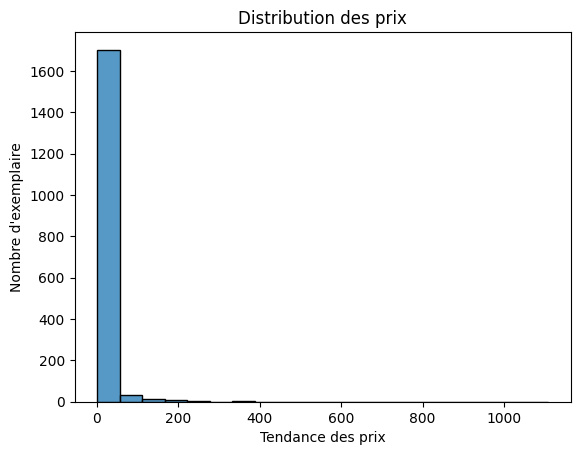

In [20]:
sns.histplot(data=sub_data, x="Price trend", bins=20, kde=False)

plt.title("Distribution des prix")
plt.xlabel("Tendance des prix")
plt.ylabel("Nombre d'exemplaire")
plt.show()

Celle ci est très étalée (voir ci dessus) avec des cartes à des prix très élevés, que l'on ne souhaite pas inclure. On va donc se contenter d'étudier les prix des cartes coutant moins de 40 euros.

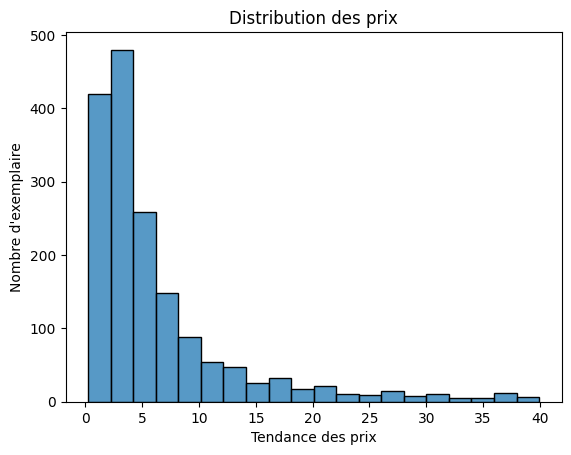

In [21]:
sub_data = sub_data[(sub_data["Price trend"] <= 40)]

sns.histplot(data=sub_data, x="Price trend", bins=20, kde=False)

plt.title("Distribution des prix")
plt.xlabel("Tendance des prix")
plt.ylabel("Nombre d'exemplaire")
plt.show()

## 3.3 Répartition des rareté

On regarde combien de carte de chaque rareté sont présente, et on enlève les raretés comportant un très faible nombre de carte

[]

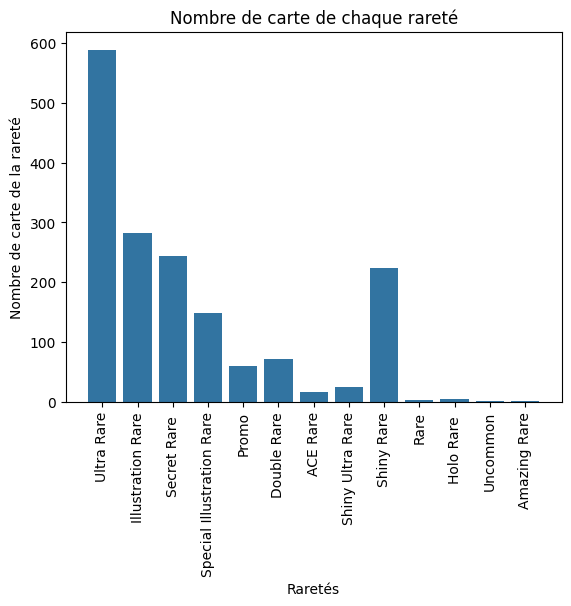

In [22]:
sns.countplot(data = sub_data, x = "Rareté")
plt.xlabel("Raretés")
plt.ylabel("Nombre de carte de la rareté")
plt.title("Nombre de carte de chaque rareté")
plt.xticks(rotation=90)

plt.plot()

[]

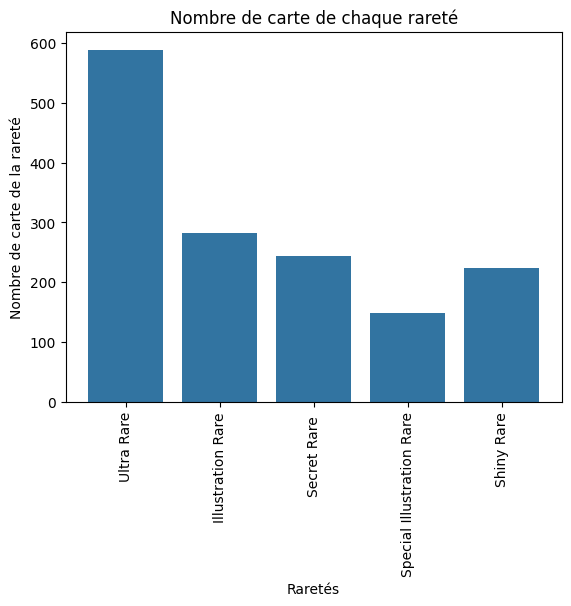

In [23]:
sub_data = sub_data[sub_data["Rareté"].map(sub_data["Rareté"].value_counts() > 100)]

sns.countplot(data = sub_data, x = "Rareté")
plt.xlabel("Raretés")
plt.ylabel("Nombre de carte de la rareté")
plt.title("Nombre de carte de chaque rareté")
plt.xticks(rotation=90)

plt.plot()

## 3.4 Répartition par extension

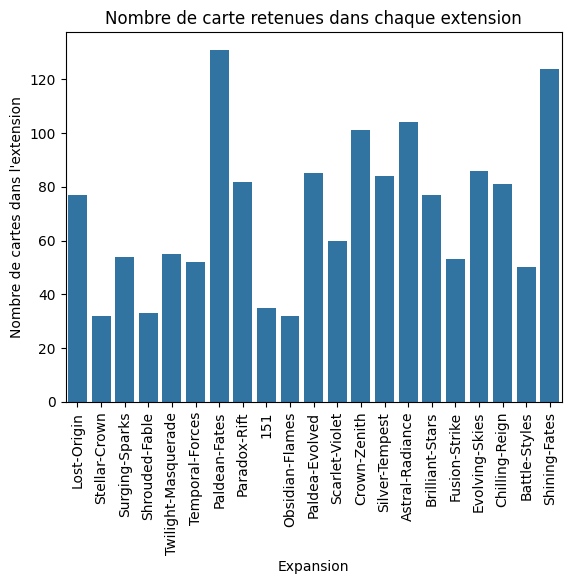

In [24]:
sns.countplot(data = sub_data, x = "Expansion")
plt.title("Nombre de carte retenues dans chaque extension")
plt.xticks(rotation=90)
plt.ylabel("Nombre de cartes dans l'extension")

plt.show()

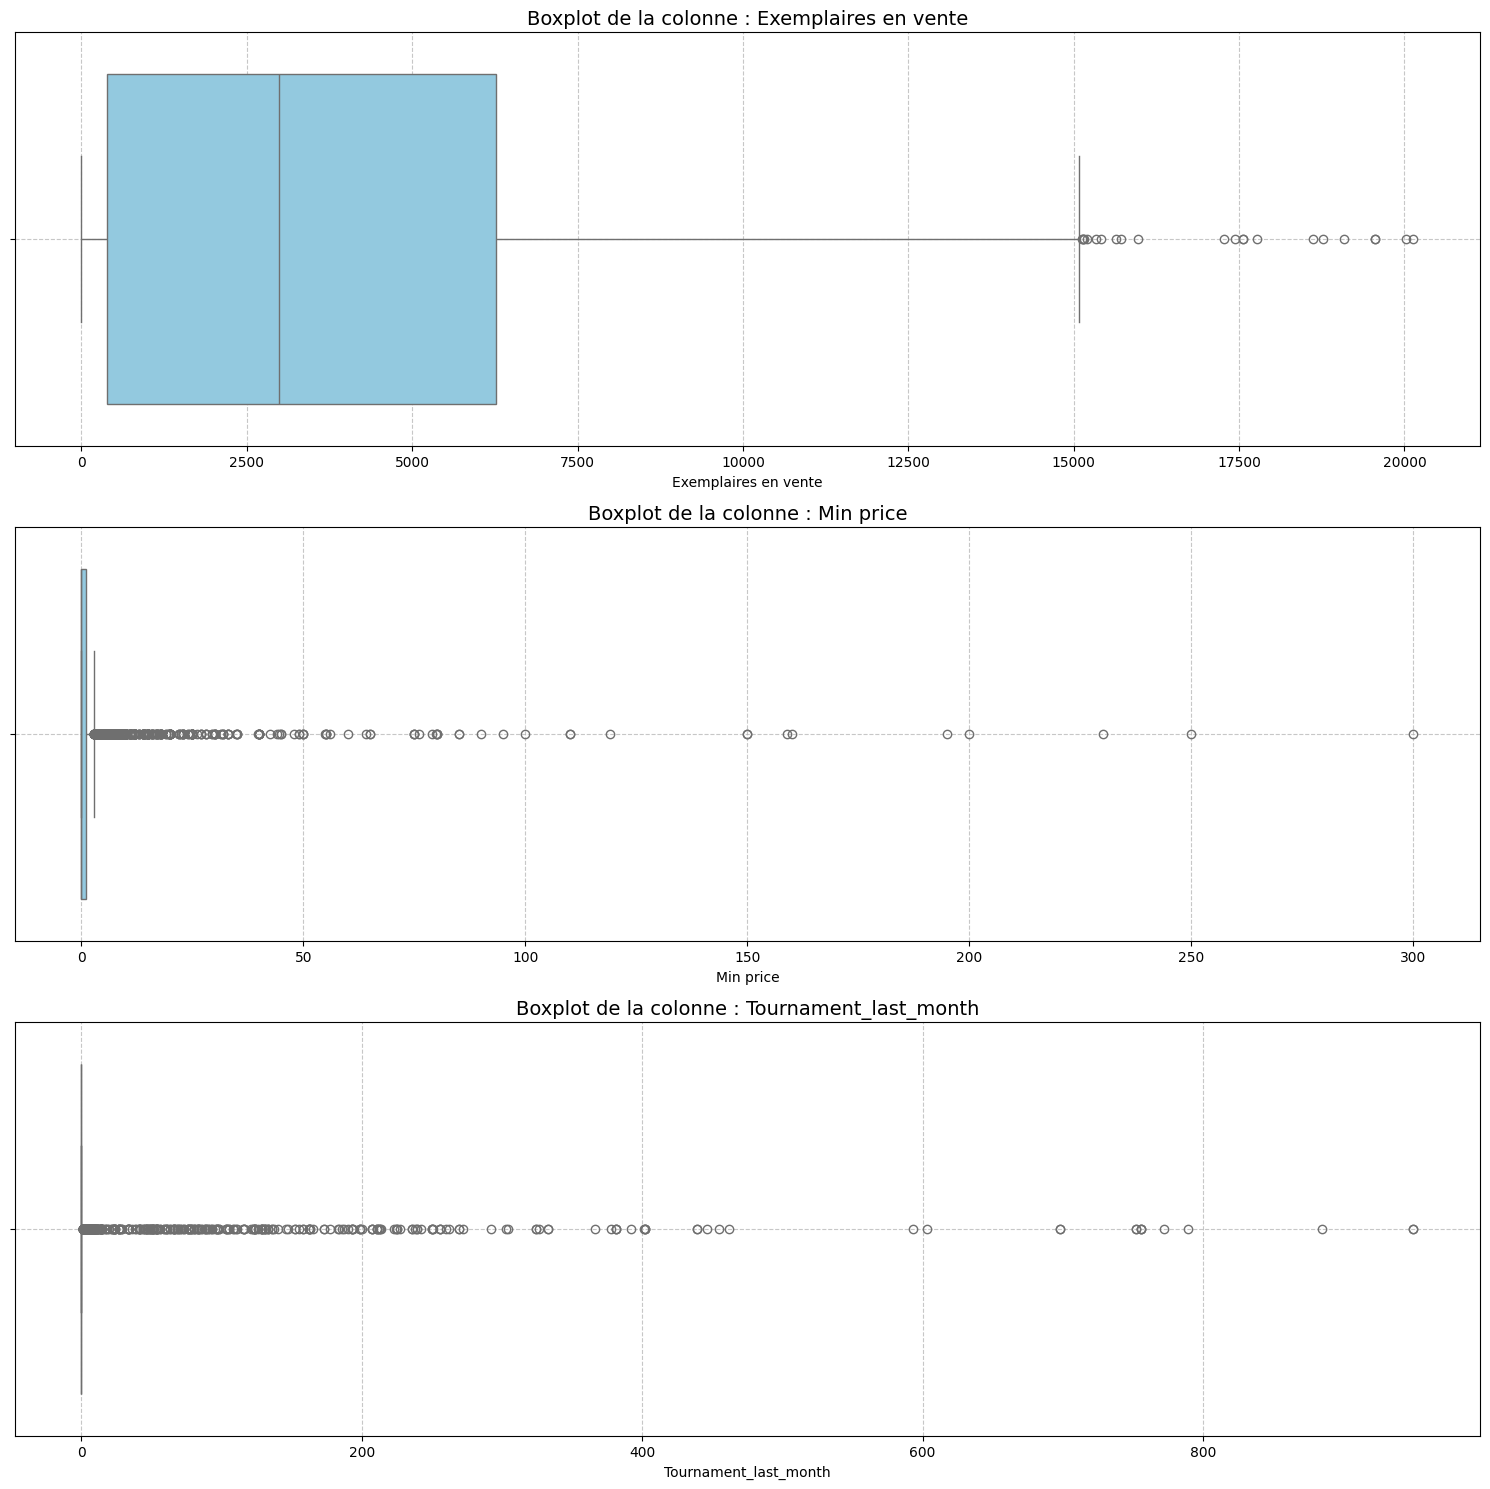

In [25]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
price_columns = ["Min price"]
numeric_columns = numeric_columns.drop('Index').union(price_columns)

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(15, len(numeric_columns) * 5))

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=data, x=col, ax=axes[i], color='skyblue')  
    axes[i].set_title(f'Boxplot de la colonne : {col}', fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)  

plt.tight_layout()
plt.show()

On ne peut tirer aucune information des boxplots sur les prix moyens sur les 7 derniers jours et les 30 derniers. En effet, les prix sont trop variables entre les différentes cartes, il n'y a aucune tendance claire qui se dégage. Toutefois, on peut mieux analyser la répartition du nombre d'exemplaires de chaque carte en vente, le prix minimum des cartes ainsique leur utilisation en tournoi.
Plus de la moitié des cartes sont vendues entre 230 eet 400 exemplaires, quelques cartes plus rares sont moins vendues et il y a certaines cartes qui sont vendues en plus grande quantité.
Pour la répartition des prix, on remarque que de très nombreuses cartes sont vendues à moins de 10 euros même s'il y a quelques anomalies avec des prix plus élevées.
Enfin, si l'on regarde l'utilisation des cartes en tournoi, il y a une répartition assez dense pour les cartes jouées moins de 200 fois le mois dernier.

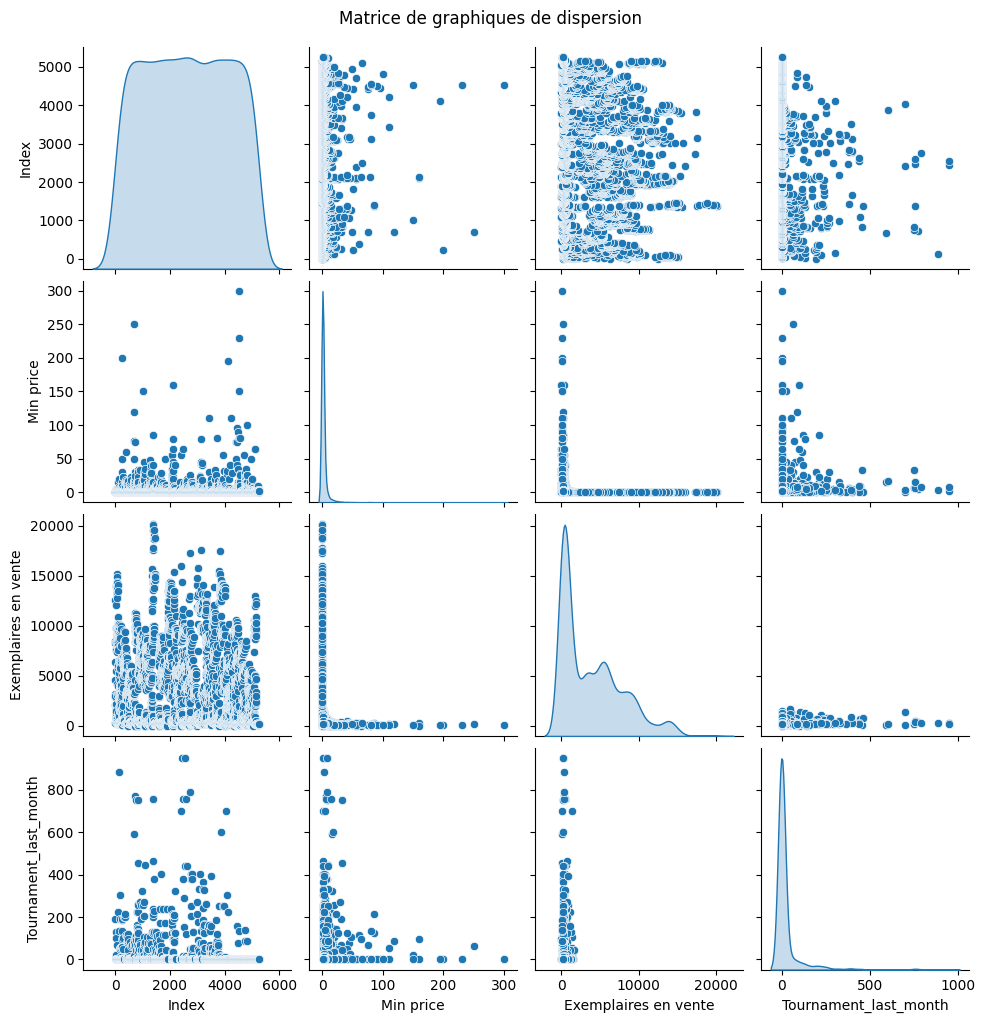

In [26]:
sns.pairplot(data, diag_kind= "kde")

plt.suptitle("Matrice de graphiques de dispersion ", y=1.02)
plt.show()

On a représenté les différents nuages de points d'une colonne en fonction d'une autre pour voir si l'on pouvait toruver des corrélations entre les variables. Il ne sert à rien de regarder les nuages de points contenant Index, cela n'apporte aucune information. 
Il ne semble pas clair qu'il y ait des corrélations entre le prix minimum d'une carte, son utilisation en tournoi ainsi que le nombre d'exemplaires en vente (sinon le nuage de points formerait une droite)

# 4. Analyse des données

On analyse les données traitées auparavant par deux méthodes: une régression linéaire et un réseau de neurone.
Notre but est ici de prédire la variable "Price trend" à partir des autres variables. On utilise donc pour cela 80% des données pour l'apprentissage, et on test notre prédiction sur les 20% des données restantes.
Notre "erreur" de prédiction sera la moyenne sur l'ensemble de l'échantillon test des erreurs entre la valeur prédite et la valeur réelle de la variable "Price trend".

## 4.0 Découpage des données

In [27]:
new_data = False
if new_data:
    learning_data, testing_data = split_data(sub_data, 0.8)
    learning_data.to_csv("data/learning_data.csv", index = False) 
    testing_data.to_csv("data/testing_data.csv", index = False) 

In [28]:
learning_data = pd.read_csv("data/learning_data.csv")
testing_data = pd.read_csv("data/testing_data.csv")

## 4.1 Première analyse sur les données: régression linéaire

On fait une première étape d'analyse dans laquelle on va juste chercher à faire une régression du prix en fonction des différentes données.
On pourrait pour cela récupérer directement utiliser des modules déjà codé, mais on préfère ici coder une fonction de zéro.
Celle ci prend en attribut un tableau de donné, une liste des nom de colonne du tableau servant d'élément explicatifs, le nom de la colonne souhaitant être expliquée, et renvoie la liste des coéfficients des variables explicatives dans la régression.
Les fonction "d'économétrie" seront dans le fichier regression_function.py.

In [29]:
from regression_function import *

In [30]:
rarity_list = sub_data["Rareté"].unique().tolist()

for rarity in rarity_list:
    learning_data[rarity] = (learning_data["Rareté"] == rarity).astype(int)
    testing_data[rarity] = (testing_data["Rareté"] == rarity).astype(int)
for expansion in expansion_list:
    learning_data[expansion] = (learning_data["Expansion"] == expansion).astype(int)
    testing_data[expansion] = (testing_data["Expansion"] == expansion).astype(int)
explicative_variables = ["Price 30 days", "Price 7 days"] + ["Exemplaires en vente"] + ["Tournament_last_month"] + rarity_list[:-1] + expansion_list[:-1]

In [31]:
beta, R2, R2_adj = mse_regression(learning_data, explicative_variables, "Price trend")
ecart_moyen = mean_error(learning_data, "Price trend", "Regression")
print("R2: ",R2)
print("R2 ajusté: ", R2_adj)
print("Erreur moyenne: ", ecart_moyen)

R2:  0.9778847519010723
R2 ajusté:  0.9773708864116823
Erreur moyenne:  0.5497899159663866


In [32]:
testing_data["Regression prediction"] = testing_data.apply(lambda row: sum([beta[i]*row[explicative_variables[i]] for i in range(len(explicative_variables))])[0], axis = 1).round(2)

testing_data[["Name", "Price trend", "Regression prediction"]].head()

,Name,Price trend,Regression prediction
0,Crustle,2.40,2.73
1,Lunatone,1.89,2.45
2,Galarian Slowking VMAX,1.55,1.90
3,Karen's Conviction,6.12,7.59
4,Charjabug,3.05,3.48


## 4.2 Une alternative dans l'analyse des données: un réseau de neurones

In [33]:
from neural_network import *

In [34]:
d = {}
l = sub_data["Expansion"].unique()
for i in range(len(l)):
    expansion = l[i]
    d[expansion] = i
learning_data["Expansion number"] = learning_data["Expansion"].map(d)
testing_data["Expansion number"] = testing_data["Expansion"].map(d)

d = {}
l = sub_data["Rareté"].unique()
for i in range(len(l)):
    rarity = l[i]
    d[rarity] = i
learning_data["Rareté number"] = learning_data["Rareté"].map(d)
testing_data["Rareté number"] = testing_data["Rareté"].map(d)

On créé un réseau de neurone avec la ligne create_new_network, qu'il faut copier directement avec la ligne qui suit.
Si on souhaite sauvegarder le réseau de neurone, on peut le copier avec la troisième ligne, ou au contraire charger un réseau existant avec la quatrième ligne commentée.

In [35]:
column_titles_list = ["Price 30 days", "Price 7 days"] + ["Tournament_last_month"] + ["Rareté number"] + ["Expansion number"]
output_column = ["Price trend"]

size_list = [len(column_titles_list), 30, len(output_column)]
function_list = []
for i in range(len(size_list)-1):
    function_list.append(Sigmoid())


path = "neural_network"
create_network_path = path + "/original_network"
working_network_path = path + "/working_network"
saved_network_path = path + "/saved_network"
i = 1

#create_new_network(path = create_network_path, loss_function = Distance(), size_list = size_list , function_list = function_list, column_titles_list= column_titles_list, output_column= output_column)
#copy_network(create_network_path, working_network_path)
#copy_network(working_network_path, saved_network_path + str(i))
#copy_network(saved_network_path + str(i), working_network_path)

In [36]:
#train_network(working_network_path, learning_data, n_epoch = 30, learning_factor= 0.00002)
train_network_score(working_network_path, learning_data, score = 1.8, n_max= 5, learning_factor= 0.00005)


mean_loss 1.7976075936131526 

1


In [37]:
apply_network(working_network_path, testing_data)
neural_prediction = testing_data.pop("Neural prediction")
testing_data.insert(6, 'Neural prediction', neural_prediction) 

testing_data["Neural prediction"] = testing_data.apply(lambda row: max(row["Neural prediction"], 0), axis = 1).round(2)
testing_data["Neural prediction error"] = testing_data["Price trend"] - testing_data["Neural prediction"]
testing_data["Regression prediction error"] = testing_data["Price trend"] - testing_data["Regression prediction"]


print(mean_error(testing_data, "Regression prediction", "Price trend"))
print(mean_error(testing_data, "Neural prediction", "Price trend"))

0.5578187919463088
1.953791946308725


In [38]:
testing_data[["Name", "Price trend", "Regression prediction", "Neural prediction", "Regression prediction error", "Neural prediction error"]].head(15)

,Name,Price trend,Regression prediction,Neural prediction,Regression prediction error,Neural prediction error
0,Crustle,2.40,2.73,0.08,-0.33,2.32
1,Lunatone,1.89,2.45,2.92,-0.56,-1.03
2,Galarian Slowking VMAX,1.55,1.90,1.97,-0.35,-0.42
3,Karen's Conviction,6.12,7.59,6.38,-1.47,-0.26
4,Charjabug,3.05,3.48,0.02,-0.43,3.03
5,Jynx ex,14.08,14.79,19.76,-0.71,-5.68
6,Celebi VMAX,13.17,11.34,6.72,1.83,6.45
7,Tornadus V,0.79,1.11,1.38,-0.32,-0.59
8,Charcadet,3.22,3.41,3.87,-0.19,-0.65
9,Rapid Strike Energy,4.20,4.23,4.44,-0.03,-0.24


## Conclusion

Nos deux modèles d'analyse nous permettent donc de prédire avec plus ou moins de précision le prix des cartes. Au vu des données que nous avons récupéré, la régression donne en pratique une meilleure approximation que le réseau de neurone. En effet, la valeur antérieur des cartes (prix sur 7 et 30 jours) est très corrélée à la tendance des prix. La régression linéaire arrive donc à prédire correctement (~0,6 euro d'écart en moyenne) notre variable d'intérêt. En revanche, le réseau de neurone est moins convainquant: l'écart est de presque 2 euros. Cela peut s'expliquer par plusieurs raisons. Premièrement, une implémentation très rudimentaire du réseau de neurone, et donc très peu optimisée, ne permettant pas un processus d'apprentissage abouti, le temps de calcul étant prohibitif. Puis, un potentiel manque de données, à la fois en terme de nombre de cartes et de données sur ces cartes. Enfin, sans connaissance particulière en machine learning, nous n'avons pas pu utiliser un modèle de réseau de neurone adapté à notre problème: nous avons simplement essayé différentes combinaisons de nombre de neurones sur chacune des couches. Il aurait pu être intéressant de voir si l'approche par réseau de neurone était plus aboutie pour une catégorisation des cartes pas tranche de prix.